# Object Detection - Car Detection


<a name='0'></a>
## Packages


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.keras.models import load_model

#settinig path to directory with support functions, images and models.
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/YOLO')
#importing function
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image

%matplotlib inline

<a name='1'></a>
##Objective

To build a car detection system using the YOLO model.


<a name='2'></a>
##YOLO

"You Only Look Once" (YOLO) algorithm is used because of its achieves high accuracy while also being able to run in real time. This algorithm requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

<a name='2-1'></a>
### Model Details

#### Inputs and outputs
- The **input** is a batch of images, and each image has the shape (608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ .



###Filtering the predictions using a threshold of class confidence scores.

In [3]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.6):
    """Filters YOLO boxes by thresholding on object and class confidence.

    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected
    """

    box_scores = box_confidence*box_class_probs
    box_classes = tf.math.argmax(box_scores,axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores,axis=-1,keepdims=False)
    #filtering out boxes with class confidence dcore less then threshold
    filtering_mask = (box_class_scores>threshold)
    scores = tf.boolean_mask(box_class_scores,filtering_mask,axis=None) #axis=0->row wise in 2d array, 1->column wise
    boxes = tf.boolean_mask(boxes,filtering_mask,axis=None)
    classes =tf.boolean_mask(box_classes,filtering_mask,axis=None)

    return scores, boxes, classes


### Non-max Suppression



### YOLO Non-max Suppression

Removing all boxes that have a large overlap with the selected boxes. Only the "best" boxes remain.


In [4]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes

    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering

    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None, ), predicted class for each box

    """

    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_threshold=0.5)

    scores = tf.gather(scores,nms_indices)
    boxes = tf.gather(boxes,nms_indices)
    classes = tf.gather(classes,nms_indices)

    return scores, boxes, classes

In [5]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


In [6]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to predicted boxes along with their scores,
    box coordinates and classes.

    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering

    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs[0],yolo_outputs[1],yolo_outputs[2],yolo_outputs[3]
    boxes = yolo_boxes_to_corners(box_xy,box_wh)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = score_threshold)
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes,image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes , iou_threshold )

    return scores, boxes, classes

In [7]:
class_names = read_classes("/content/drive/MyDrive/Colab Notebooks/YOLO/model_data/coco_classes.txt")
anchors = read_anchors("/content/drive/MyDrive/Colab Notebooks/YOLO/model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

<a name='3-2'></a>
###Loading a Pre-trained Model


In [8]:
yolo_model = load_model("/content/drive/MyDrive/Colab Notebooks/YOLO/model_data", compile=False)

In [9]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 608, 608, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 608, 608, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 608, 608, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 608, 608, 32)         0         ['batch_normalizati

In [49]:
def draw_boxes(image, boxes, box_classes, class_names, scores=None):
    """Draw bounding boxes on image.

    Draw bounding boxes with class name and optional box score on image.

    Args:
        image: An `array` of shape (width, height, 3) with values in [0, 1].
        boxes: An `array` of shape (num_boxes, 4) containing box corners as
            (y_min, x_min, y_max, x_max).
        box_classes: A `list` of indicies into `class_names`.
        class_names: A `list` of `string` class names.
        scores: A `list` of scores for each box.

    Returns:
        A copy of `image` modified with given bounding boxes.
    """
    print(boxes)
    #image = Image.fromarray((image * 255).astype('uint8'))
    try:
        font = ImageFont.truetype("/content/drive/MyDrive/Colab Notebooks/YOLO/glorious-christmas-font/GloriousChristmas-BLWWB.ttf",
                                  size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    except IOError:
        font = ImageFont.load_default()

    thickness = (image.size[0] + image.size[1]) // 300
    colors = get_colors_for_classes(len(class_names))

    for i, c in enumerate(box_classes):
        box_class = class_names[c]
        box = boxes[i]

        if scores is not None:
            score = scores[i]
            label = '{} {:.2f}'.format(box_class, score)
        else:
            label = '{}'.format(box_class)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # Draw the box
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i], outline=colors[c])

        # Draw the label background
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])

        # Draw the label text
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

    return np.array(image)


In [86]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.

    Arguments:
    image_file -- name of an image stored in the "images" folder.

    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes

    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes.
    """

    # Preprocess your image
    image, image_data = preprocess_image(image_file, model_image_size = (608, 608))

    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    # print("@@@@@@")
    # print(yolo_outputs)
    # print("@@@@@@")
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.4, 0.6)

    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    colors = get_colors_for_classes(len(class_names))
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    #image.save(os.path.join("out", image_file), quality=100)
    save_path=image_file.split("images/")[1]
    #print("the save path is",save_path)
    image.save("/content/drive/MyDrive/Colab Notebooks/YOLO/out/"+save_path,quality=100)
    output_image = Image.open("/content/drive/MyDrive/Colab Notebooks/YOLO/out/"+save_path)
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 7 boxes for images//content/drive/MyDrive/Colab Notebooks/YOLO/images/myimg6.jpg
tf.Tensor(
[[6.1548914e+02 6.5672302e+02 9.6082281e+02 9.4626294e+02]
 [6.6092316e+02 4.4372006e+02 7.7152759e+02 6.5833521e+02]
 [6.7234241e+02 7.7507210e+01 7.1410828e+02 1.5174088e+02]
 [8.4430426e+02 7.9773545e-01 1.1178431e+03 4.9072708e+01]
 [6.5960565e+02 2.2420155e+02 7.4210474e+02 3.1896176e+02]
 [6.2826788e+02 1.4679491e+02 7.0321356e+02 2.7573032e+02]
 [6.6456604e+02 6.0319561e+01 6.9194550e+02 9.5822128e+01]], shape=(7, 4), dtype=float32)
truck 0.62 (657, 615) (946, 961)
car 0.60 (444, 661) (658, 772)
car 0.51 (78, 672) (152, 714)
car 0.50 (1, 844) (49, 1118)
car 0.47 (224, 660) (319, 742)
truck 0.46 (147, 628) (276, 703)
car 0.41 (60, 665) (96, 692)
-----------
tf.Tensor(
[0.6234088  0.5968253  0.51141953 0.502296   0.46822    0.45660698
 0.41453126], shape=(7,), dtype=float32)


<ipython-input-49-cab537873d3a>:39: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-49-cab537873d3a>:39: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-49-cab537873d3a>:39: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-49-cab537873d3a>:39: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-49-cab537873d3a>:39: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

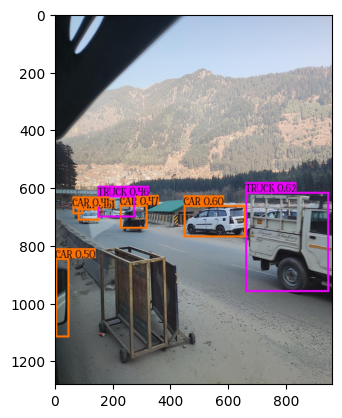

In [92]:
out_scores, out_boxes, out_classes = predict("/content/drive/MyDrive/Colab Notebooks/YOLO/images/myimg6.jpg")
print("-----------")
print(out_scores)
# print(out_boxes)
# print(out_classes)
# print("-----------")

<a name='4'></a>
## Summary for YOLO

- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output.
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers.
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture.
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and 80 is the number of classes we'd like to detect
- Boxes are selcted on basis of:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output.

<a name='5'></a>
## 5 - References


- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/)
- DeepLearning.ai

### Car detection dataset

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The Drive.ai Sample Dataset</span> (provided by drive.ai) is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. Thanks to Brody Huval, Chih Hu and Rahul Patel for  providing this data.